A lot of the material is taken/inspired from Martin Gorner's presentation https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size_train = 64
batch_size_test = 1024

# Load the MNIST Dataset

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_data = torchvision.datasets.MNIST(
    root='data/',
    train=True,
    download=True,
    transform=transform
)

test_data = torchvision.datasets.MNIST(
    'data/', 
    train=False, 
    download=True,
    transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size_train, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size_test, 
    shuffle=True)

# train_data.train_data.to(device)  # put data into GPU entirely
# train_data.train_labels.to(device)

# test_data.test_data.to(device)  # put data into GPU entirely
# test_data.test_labels.to(device)

/home/piyush/.virtualenvs/ml_env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
dir(train_data)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_check_legacy_exist',
 '_format_transform_repr',
 '_is_protocol',
 '_load_data',
 '_load_legacy_data',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'mirrors',
 'processed_folder',
 'raw_folder',
 'resources',
 'root',
 'target_transform',
 'targets',
 'test_data',
 'test_file',
 'test_labels',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'transforms']

## Visualizing

In [6]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

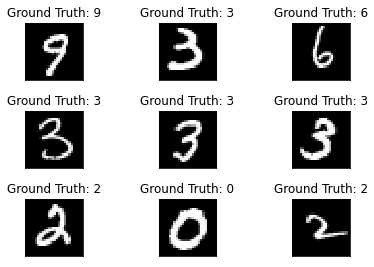

In [7]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title(f"Ground Truth: {example_targets[i]}")
  plt.xticks([])
  plt.yticks([])


# Architecture

## Flattening
<figure>
    <img src="images/mnist_flatten.png" alt="A kitten">
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure>  

## Matrix Representation
<figure>
    <img src="images/mnist_matrix_multiplication_batch.png" alt="A kitten">
    <br><br>
    <figcaption>Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd <figcaption>
<figure> 

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, n_classes):
        super().__init__()
        self.nn_stack = nn.Sequential(
            nn.Linear(input_size, n_classes)
        )
    def forward(self, x):
        output = self.nn_stack(x)
        return nn.functional.log_softmax(output)

In [12]:
def one_train_epoch(train_data, model, loss_fn, optimizer):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        data = data.view(-1, 784)
        optimizer.zero_grad()
        predictions = model(data)
        loss = loss_fn(predictions, target)
        
        if batch_idx % 100 == 0:
            print(f"loss: {loss.item():>7f}  [{batch_idx * len(data):>5d}/{len(train_loader.dataset):>5d}]")
        
        loss.backward()
        optimizer.step()
    print(f"loss: {loss.item():>7f}  [{batch_idx * len(data):>5d}/{len(train_loader.dataset):>5d}]")
    return loss

In [13]:
model = NeuralNetwork(784, 10).to(device)

In [14]:
epochs = 10
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = learning_rate, 
#                              weight_decay=0.0001
                            )
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=6, verbose=True)

In [15]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}, lr: {scheduler.optimizer.param_groups[0]['lr']}\n-------------------------------")
    loss = one_train_epoch(train_loader, model, loss_fn, optimizer)
    scheduler.step(loss)
print("Done!")

Epoch 1, lr: 0.001
-------------------------------
loss: 2.517169  [    0/60000]


/tmp/ipykernel_22813/1067902870.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(output)


loss: 0.449358  [ 6400/60000]
loss: 0.330546  [12800/60000]
loss: 0.401052  [19200/60000]
loss: 0.429391  [25600/60000]
loss: 0.225101  [32000/60000]
loss: 0.195436  [38400/60000]
loss: 0.377609  [44800/60000]
loss: 0.341250  [51200/60000]
loss: 0.249213  [57600/60000]
loss: 0.138847  [29984/60000]
Epoch 2, lr: 0.001
-------------------------------
loss: 0.451974  [    0/60000]
loss: 0.531141  [ 6400/60000]
loss: 0.220913  [12800/60000]
loss: 0.203612  [19200/60000]
loss: 0.269233  [25600/60000]
loss: 0.129342  [32000/60000]
loss: 0.303108  [38400/60000]
loss: 0.388665  [44800/60000]
loss: 0.303354  [51200/60000]
loss: 0.220795  [57600/60000]
loss: 0.288637  [29984/60000]
Epoch 3, lr: 0.001
-------------------------------
loss: 0.256508  [    0/60000]
loss: 0.674824  [ 6400/60000]
loss: 0.166363  [12800/60000]
loss: 0.293555  [19200/60000]
loss: 0.236924  [25600/60000]
loss: 0.227437  [32000/60000]
loss: 0.152655  [38400/60000]
loss: 0.223930  [44800/60000]
loss: 0.355659  [51200/60000